# Analiza zbioru danych 🎹 Spotify Tracks Dataset

W tym notatniku zaprezentowana zostanie analiza zbioru dannych [🎹 Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset). Najpierw przeprowadzona zostanie wstępna eksploracyjna analiza danych, a następnie wytrenowane zostaną modele, które przewidywać będą gatunek muzyki dla danej piosenki na podstawie atrybutów dostępnych w zbiorze danych.

### Import niezbędnych bibliotek oraz pakietów

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.float_format', lambda x: '%.4f' % x)
RANDOM_STATE = 60
np.random.seed(RANDOM_STATE)

# Opis zbioru danych

## Wczytanie zbioru danych oraz wstępne przetwarzanie

Z całego zbioru danych zostaną wyfiltrowane tylko niektóre gatunki, które nie zależą od pochodzenia/narodowości twórcy oraz które są popularne. Dodatkowo zamiast 20 gatunków muzyki osobno, rozpatrywane będą jedynie 4: rock, chill/relax, classical, pop/dance. Poniżej zamieszczona została mapa, na podstawie której odpowiednie gatunki zostały zmienione na jeden z czterech wymienionych. Zadaniem będzie więc klasyfikacja wieloklasowa.

In [30]:
GENRES_MAP = {
    'alt-rock': 'rock',
    'ambient': 'chill/relax',
    'chill': 'chill/relax',
    'classical': 'classical',
    'dance': 'pop/dance',
    'disco': 'pop/dance',
    'edm': 'pop/dance',
    'electro': 'pop/dance',
    'hard-rock': 'rock',
    'heavy-metal': 'rock',
    'hip-hop': 'pop/dance',
    'indie-pop': 'pop/dance',
    'opera': 'classical',
    'piano': 'classical',
    'pop': 'pop/dance',
    'punk-rock': 'rock',
    'rock-n-roll': 'rock',
    'rock': 'rock',
    'sleep': 'chill/relax',
    'study': 'chill/relax'
}
GENRES = list(GENRES_MAP.keys())
COLUMNS = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre']
COLUMNS_DUPLICATES = ['artists', 'track_name', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'track_genre']
COLUMNS_NUMERICAL = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
COLUMNS_NOMINAL = ['explicit', 'mode']

Przykładowe 5 próbek ze zbioru danych.

In [31]:
df_original = pd.read_csv("data/dataset.csv", index_col=0)
df_original = df_original[df_original['track_genre'].isin(GENRES)].reset_index().drop(columns='index')
df_original['track_genre'] = df_original['track_genre'].replace(GENRES_MAP)
df_original.sample(5, random_state=RANDOM_STATE)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
7774,2KnuaZYoGzDoHiBTNYOTXG,Billie Eilish,Happier Than Ever,Billie Bossa Nova,76,196730,False,0.8950,0.3890,7,-11.0360,0,0.1100,0.2220,0.0346,0.1050,0.5490,110.0230,4,pop/dance
11868,2ndWbjiiNBEOrlfToKlABE,Death Cab for Cutie,Plans,I Will Follow You into the Dark,64,189400,False,0.5810,0.1630,5,-14.6860,1,0.0447,0.9230,0.0000,0.1180,0.4750,77.7480,4,pop/dance
17117,5AYpoODLJZtDlP64IbpHCj,Panic! At The Disco,Rock Brandneu,Don't Let the Light Go Out,2,229517,False,0.4920,0.5900,4,-4.0320,0,0.0313,0.0011,0.0023,0.2710,0.1790,117.6370,4,rock
9915,0gxPoAXnDDSagqDcUoH2tv,Die Apokalyptischen Reiter,Samurai,Wahnsinn,20,185786,False,0.4380,0.9780,0,-2.4870,0,0.0936,0.0001,0.0001,0.2190,0.5560,97.0060,4,rock
7485,5eYQMChHFGtMlRPZicBtMC,Topic;A7S,pov: it's 2020,Breaking Me,0,166793,False,0.7890,0.7200,8,-5.6520,0,0.2170,0.2230,0.0000,0.1290,0.6640,122.0310,4,pop/dance


## Opis zbioru danych

Zbiór danych posiada 20 atrybutów. Pogrubioną czcionką oznaczone zostały te, które będą używane w dalszej analizie danych oraz podczas uczenia modeli.
1. track_id - unikalny identyfikator utworu w ramach Spotify,
2. artists - zbiór artystów, którzy są autorami piosenki,
3. album_name - nazwa albumu, na którym pojawia się piosenka,
4. track_name - nazwa piosenki,
5. **popularity** - popularność piosenki wyrażona na skali od 0 do 100. Wyliczana jest ona na podstawie algorytmu przygotowanego przez Spotify, który bierze pod uwagę takie czynniki jak liczba odtworzeń utworu w serwisie oraz ich aktualności (czy utwór jest popularny teraz czy w przeszłości),
6. **duration_ms** - długość trwania pionseki w milisekundach,
7. **explicit** - wartość bool określająca czy piosenka posiada niecenzuralne słowa,
8. **danceability** - wartość od 0.0 do 1.0 określająca jak bardzo piosenka nadaje się do tańczenia. Wartość wyliczana jest między innymi na podstawie tempa czy też stabilności rytmu,
9. **energy** - wartość od 0.0 do 1.0 reprezentująca miarę intensywności utworu. Przykładowo piosenki, które są szybkie, głośne oraz hałaśliwe mają wysoką wartość energii,
10. key - tonacja, w której jest piosenka określona w notacji [Pitch class](https://en.wikipedia.org/wiki/Pitch_class),
11. **loudness** - średnia głośność piosenki wyrażona w decybelach,
12. **mode** - określenie czy piosenka jest w tonacji dur (1) czy moll (0),
13. **speechiness** - wartość od 0.0 do 1.0 odpowiadająca za obecność słów w piosence. Przykładowo poezja czytana albo podcast posiada wartość 1.0,
14. **acousticness** - wartość od 0.0 do 1.0 określająca jak bardzo akustyczny jest utwór,
15. **instrumentalness** - wartość od 0.0 do 1.0 określająca czy utwór zawiera słowa. Przykładowo piosenki, które są zaklasyfikowane jako Rap będą miały niską wartość instrumentalness. Im większa wartość tego atrybutu, tym większa pewność, że utwór nie posiada słów,
16. liveness - wartość od 0.0 do 1.0 określająca pewność z jaką utwór został wykonany na żywo,
17. **valence** - wartość od 0.0 do 1.0 określająca jak bardzo pozytywny jest utwór. Piosenki, które mają wartość 1.0 na tym atrybucie będą radosne, a z małymi wartościami (bliskimi 0.0) będą smutne,
18. **tempo** - średnia tempo utworu [BPM](https://en.wikipedia.org/wiki/Tempo),
19. time_signature - oszacowane taktowanie utworu,
20. **track_genre** - gatunek muzyki, do którego należy piosenka.

In [32]:
df_original

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5E30LdtzQTGqRvNd7l6kG5,The Neighbourhood,Wiped Out!,Daddy Issues,87,260173,False,0.5880,0.5210,10,-9.4610,1,0.0329,0.0678,0.1490,0.1230,0.3370,85.0120,4,rock
1,2Y0iGXY6m6immVb2ktbseM,MGMT,Little Dark Age,Little Dark Age,83,299960,False,0.7050,0.7120,6,-6.1560,1,0.0385,0.0102,0.0009,0.1000,0.6200,97.5120,4,rock
2,2K7xn816oNHJZ0aVqdQsha,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,Softcore,86,206280,False,0.5750,0.5680,9,-5.5090,0,0.0300,0.0484,0.0004,0.2860,0.3700,93.9860,4,rock
3,2QjOHCTQ1Jl3zawyYOpxh6,The Neighbourhood,I Love You.,Sweater Weather,93,240400,False,0.6120,0.8070,10,-2.8100,1,0.0336,0.0495,0.0177,0.1010,0.3980,124.0530,4,rock
4,7zwn1eykZtZ5LODrf7c0tS,The Neighbourhood,Hard To Imagine The Neighbourhood Ever Changing,You Get Me So High,83,153000,False,0.5510,0.8810,7,-6.0990,0,0.0542,0.1860,0.0791,0.1520,0.3870,88.0360,4,rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0p9HloqJbkgokaktOhiwkn,"Sarah, the Illstrumentalist",FLOWERS,Chamomile,6,140199,False,0.6400,0.2960,3,-9.1420,0,0.0314,0.0238,0.8960,0.1530,0.3370,112.0180,5,chill/relax
19996,2RpHErrNFoo8A7MKAQS7tD,DGHTR,HoriZon Butterfly,Red Maple,2,119111,False,0.8140,0.2260,0,-13.2780,1,0.1010,0.4930,0.9040,0.4460,0.2000,135.0460,4,chill/relax
19997,2nHUre6dQezPvxBkeTAba5,"Sarah, the Illstrumentalist",Constellations,Capricornus,6,142521,False,0.7690,0.7160,11,-8.8440,0,0.0514,0.0161,0.9460,0.1520,0.5980,137.9950,4,chill/relax
19998,63QCKDyQB7OoiWOfwWkysb,"Sarah, the Illstrumentalist",Pocket Full of Crystals: Vol 2,Orange Jasper,6,145000,False,0.6750,0.6940,9,-7.6890,0,0.0838,0.4450,0.9280,0.1090,0.6250,179.9600,4,chill/relax


In [66]:
df_original.to_csv("data/dataset_cleaned.csv", index=False)
df = df_original[COLUMNS].copy()
df['mode'] = df['mode'].astype('bool')
df.dtypes

popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
valence             float64
tempo               float64
track_genre          object
dtype: object

Większość z rozważanych atrybutów jest typu int lub float, natomiast są również atrybuty nominalne takie jak: *explicit* przyjmująca wartość boolowską - Prawda lub Fałsz, oraz *mode* przyjmująca wartość boolowską - Prawda jeżeli tonacja dur, Fałsz jeżeli tonacja moll. Ostatnim z atrybutów jest klasa, do której chcemy przydzielać piosenki.

In [67]:
df.isnull().values.any()

False

W przygotowanym zbiorze danych nie ma wartości brakujących.

In [68]:
df.describe()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
count,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000,20000.0000
mean,34.4948,210724.3839,0.5359,0.5700,-10.0312,0.0689,0.3770,0.2074,0.4406,117.6503
std,27.0183,100639.5189,0.1942,0.2845,7.2496,0.0650,0.3705,0.3578,0.2599,32.0120
min,0.0000,17453.0000,0.0000,0.0000,-49.5310,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,162897.0000,0.4090,0.3610,-12.0375,0.0354,0.0282,0.0000,0.2270,94.0385
50%,35.0000,200081.5000,0.5580,0.6130,-7.4725,0.0460,0.2220,0.0001,0.4310,118.1840
75%,59.0000,242437.5000,0.6860,0.8100,-5.2527,0.0712,0.7540,0.2182,0.6390,137.8893
max,100.0000,4120258.0000,0.9650,1.0000,1.0230,0.7660,0.9960,1.0000,0.9920,215.5130


W powyższej tabeli przedstawione zostały statystyki dotyczące każdego z atrybutów liczbowych. Można zauważyć, że dla niektórych modeli/klasyfikatorów trzeba będzie sprawdzić również wersję z normalizacją/standaryzacją danych, ponieważ istnieje duża różnica (parę rzędów wielkości) pomiędzy wartościami dla atrybutów np. duration_ms vs acousticness.

Liczba łącznie próbek/przypadków: 20000, liczba rozpatrywanych gatunków: 4


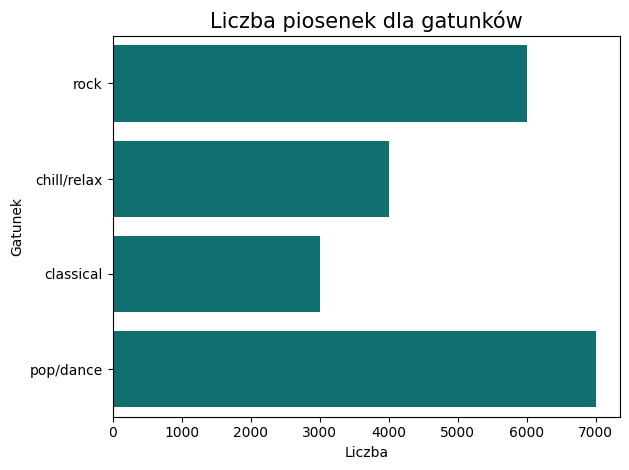

In [69]:
print(f"Liczba łącznie próbek/przypadków: {len(df)}, liczba rozpatrywanych gatunków: {len(df.track_genre.unique())}")
sns.countplot(df['track_genre'], color='teal')
plt.title("Liczba piosenek dla gatunków", fontsize=15)
plt.tight_layout()
plt.ylabel("Gatunek")
plt.xlabel("Liczba")
plt.show()

Na powyższym wykresie możemy zaobserwować ile piosenek w przygotowanym zbiorze danych należy do danego gatunku muzyki. Najwięcej, bo aż 7000 piosenek jest rodzaju "pop/dance", a najmniej (3000) jest rodzaju "classical". Nie można jednak mówić o danych mocno niezbalansowanych, ponieważ każdy z gatunków ma co najmniej 15% próbek w zbiorze danych. Wszystkich próbek jest 20000.

# Interpretacja przypadków ze zbioru danych

W tej sekcji przedstawione zostaną trzy konkretne przypadki ze zbioru danych.

In [70]:
df.loc[[14137, 3468, 17911], :]

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,track_genre
14137,85,231826,False,0.7600,0.7030,-5.4120,True,0.0540,0.1030,0.0000,0.5700,95.9970,pop/dance
3468,66,259493,False,0.2250,0.0047,-30.9280,False,0.0509,0.9920,0.8810,0.1860,163.6650,classical
17911,75,243773,False,0.8150,0.4380,-14.5220,False,0.0346,0.2160,0.0005,0.5520,108.9650,rock


In [71]:
df_original.loc[[14137, 3468, 17911], ['artists', 'album_name', 'track_name']]

,artists,album_name,track_name
14137,Taylor Swift,1989 (Deluxe),Blank Space
3468,Frédéric Chopin;Mikhail Pletnev,"Chopin: Piano Sonata No. 2, Nocturnes, Barcaro...","Chopin: Nocturne No. 20 in C-Sharp Minor, Op. ..."
17911,Survivor,Eye Of The Tiger,Eye of the Tiger


##### Blank Space - Taylor Swift - pop/dance

Pierwszą z interpretowanych piosenek jest 'Black Space' Taylor Swift. Należy ona do gatunku pop/dance, więc dość naturalnym jest, że jej popularność jest na wysokim poziomie i wynosi ona 85 (gdzie maksymalna wartość to 100, a piosenka nie jest najnowsza, ponieważ pochodzi z 2014 roku). Długość trwania wynosi nieco poniżej 4 minut, co jest standardową długością dla piosenek. Nie posiada ona niecenzuralnych słów. Wartości danceability i energy zostały ustalone na około 0.7, czyli wartość dość zrozumiałą dla piosenek z gatunku pop. Loudness wynosi -5.4 (ponieważ piosenka jest dość głośna i miejscami hałaśliwa). Speechiness, acousticness i instumentalness mają niskie wartości, ponieważ w piosence nie występują tylko słowa ani tylko muzyka. Valence ma średnią wartość wynoszącą 0.57. Tempo jest dość niskie jak na piosenkę pop, poniewaz wynosi zaledwie 95.

##### Nocturne In C-Sharp Minor, Op. Posth. - Frédéric Chopin;Mikhail Pletnev - classical

Drugim z omawianych utworów jest Nokturn cis-moll Fryderyka Chopina wykonany przez Mikhaila Pletneva. Należy on do gatunku classical, więc można spodziewać się po nim odmiennych wartości niż dla poprzedniej piosenki. Popularność wynosi jest już nieco mniejsza - wynosi 66. Długość utworu nadal nie odbiega od normy i wynosi nieco ponad 4 minuty. Oczywiście (co nie powinno być zdziwieniem) wartość explicit ustawiona jest na fałsz. Na atrybutach danceability, energy, loudness oraz speechiness uzyskuje niskie wartości, ale acousticness i instrumentalness mają wysokie wartości (w utworze nie ma żadnych słów - jest grany na fortepianie). Mode ma oczywiście wartość false, ponieważ utwór jest w tonacji cis-moll. Atrybut valence ma niską wartość, ponieważ nokturn nie jest energiczny. Za to tempo utworu jest dość wysokie (co może być nieoczywiste, ponieważ zazwyczaj wyobrażamy sobie utwory klasyczne jako powolne).

##### Eye of the Tiger - Survivor

Ostatnim z interpretowanych utworów jest 'Eye of the Tiger' zespołu Survivor. Należy on do gatunku rock. Popularność jest dość wysoka i wynosi 75 (jest to prawdopodobnie jedna z najbardziej rozpoznawalnych piosenek lat '80). Długość utworu jest standardowa i wynosi około 4 minut. Podobnie jak w przypadku pierwszej z 'Black Space' danceability i energy są dość wysokie (chociaż wartość energy akurat w przypadku tej piosenki jest dość niska). Loudness jest również dość niska jak na piosenkę 'rock'. Oczywiście speechiness, acousticness i instrumentalness są niskie, a valence w połowie pomiędzy 0 i 1.

# Eksploracyjna analiza danych

W tej sekcji przedstawione zostaną wykresy oraz analizy, które pozwolą na zinterpretowanie oraz lepsze zrozumienie danych z podziałem na poszczególne z czterech analizowanych gatunków. Analizy w przeciwieństwie do interpretacji pojedynczych przypadków będą obejmowały cały zbiór danych.

## Wizualizacja danych 2D

Na początku przedstawiona zostanie wizualizacja danych w przestrzeni 2D uzyskanej po przekształceniu kolumn, które są typu numerycznego przy pomocy metody PCA. Przed transformacją następuje oczywiście standaryzacja wartości.

[0.37484548 0.12431486]


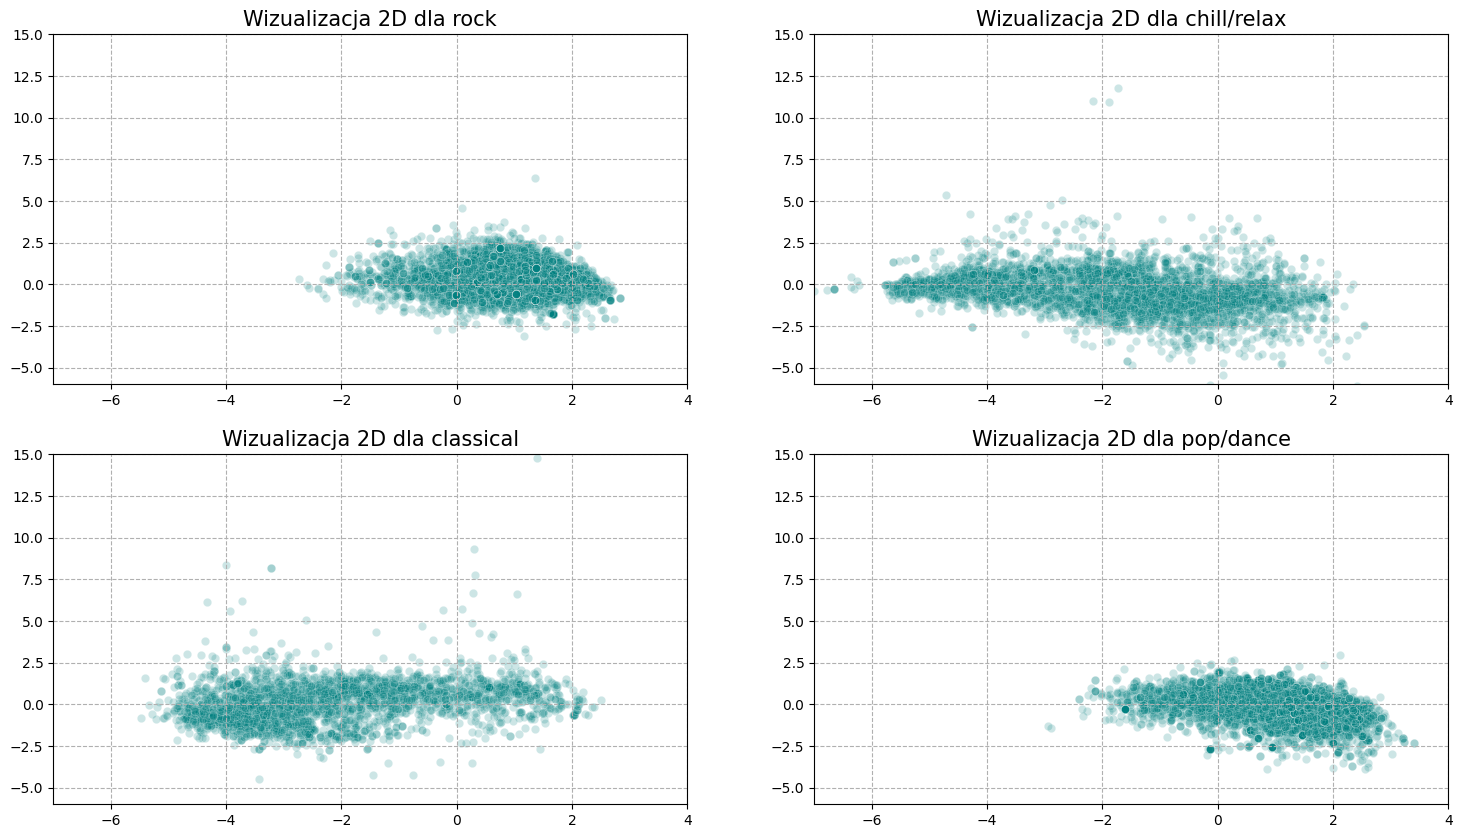

In [72]:
X_pca = df[COLUMNS_NUMERICAL]
scaler = StandardScaler()
X_pca = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)
print(pca.explained_variance_ratio_)
X_pca = pd.DataFrame(X_pca, columns=['x', 'y'])
X_pca['track_genre'] = df['track_genre']

plt.figure(figsize=(18, 10))
for i, genre in enumerate(X_pca.track_genre.unique()):
    plt.subplot(2, 2, i + 1)
    ax = sns.scatterplot(X_pca[X_pca['track_genre'] == genre], x='x', y='y', alpha=0.2, color='teal')
    ax.set_xlim(-7,4)
    ax.set_ylim(-6,15)
    plt.title(f"Wizualizacja 2D dla {genre}", fontsize=15)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(linestyle='--')

plt.show();

Na powyższym wykresie przedstawiona została wizualizacja 2D dla każdego z gatunków. Wyjaśnialność na pierwszej składowej wynosi 0.37, a na drugiej 0.12. Osie dla wszystkich wykresów zostały ustawione na taki sam zakres, aby możliwe było porównanie. Jak widać, klasy nachodzą na siebie i to w znacznym stopniu (w szczególności rock oraz pop i chill/relax oraz classical). Rock oraz pop/dance są bardziej skupione wokół punktu (0, 0), podczas gdy classical oraz chill/relax mają bardziej spłaszczony charakter i przyjmują szerszy zakres wartości na osi X (od około -6 do 2).

## Analiza atrybutów numerycznych

W tej części przeanalizowane zostaną atrybuty numeryczne w zbiorze danych.

### Rozkład dla poszczególnych atrybutów

Dla atrybutów, które przyjmują wartości ciągłe wyświetlone zostaną histogramy z "Kernel density estimate (KDE)" oraz wykresy typu boxplot z podziałem na poszczególne gatunki.

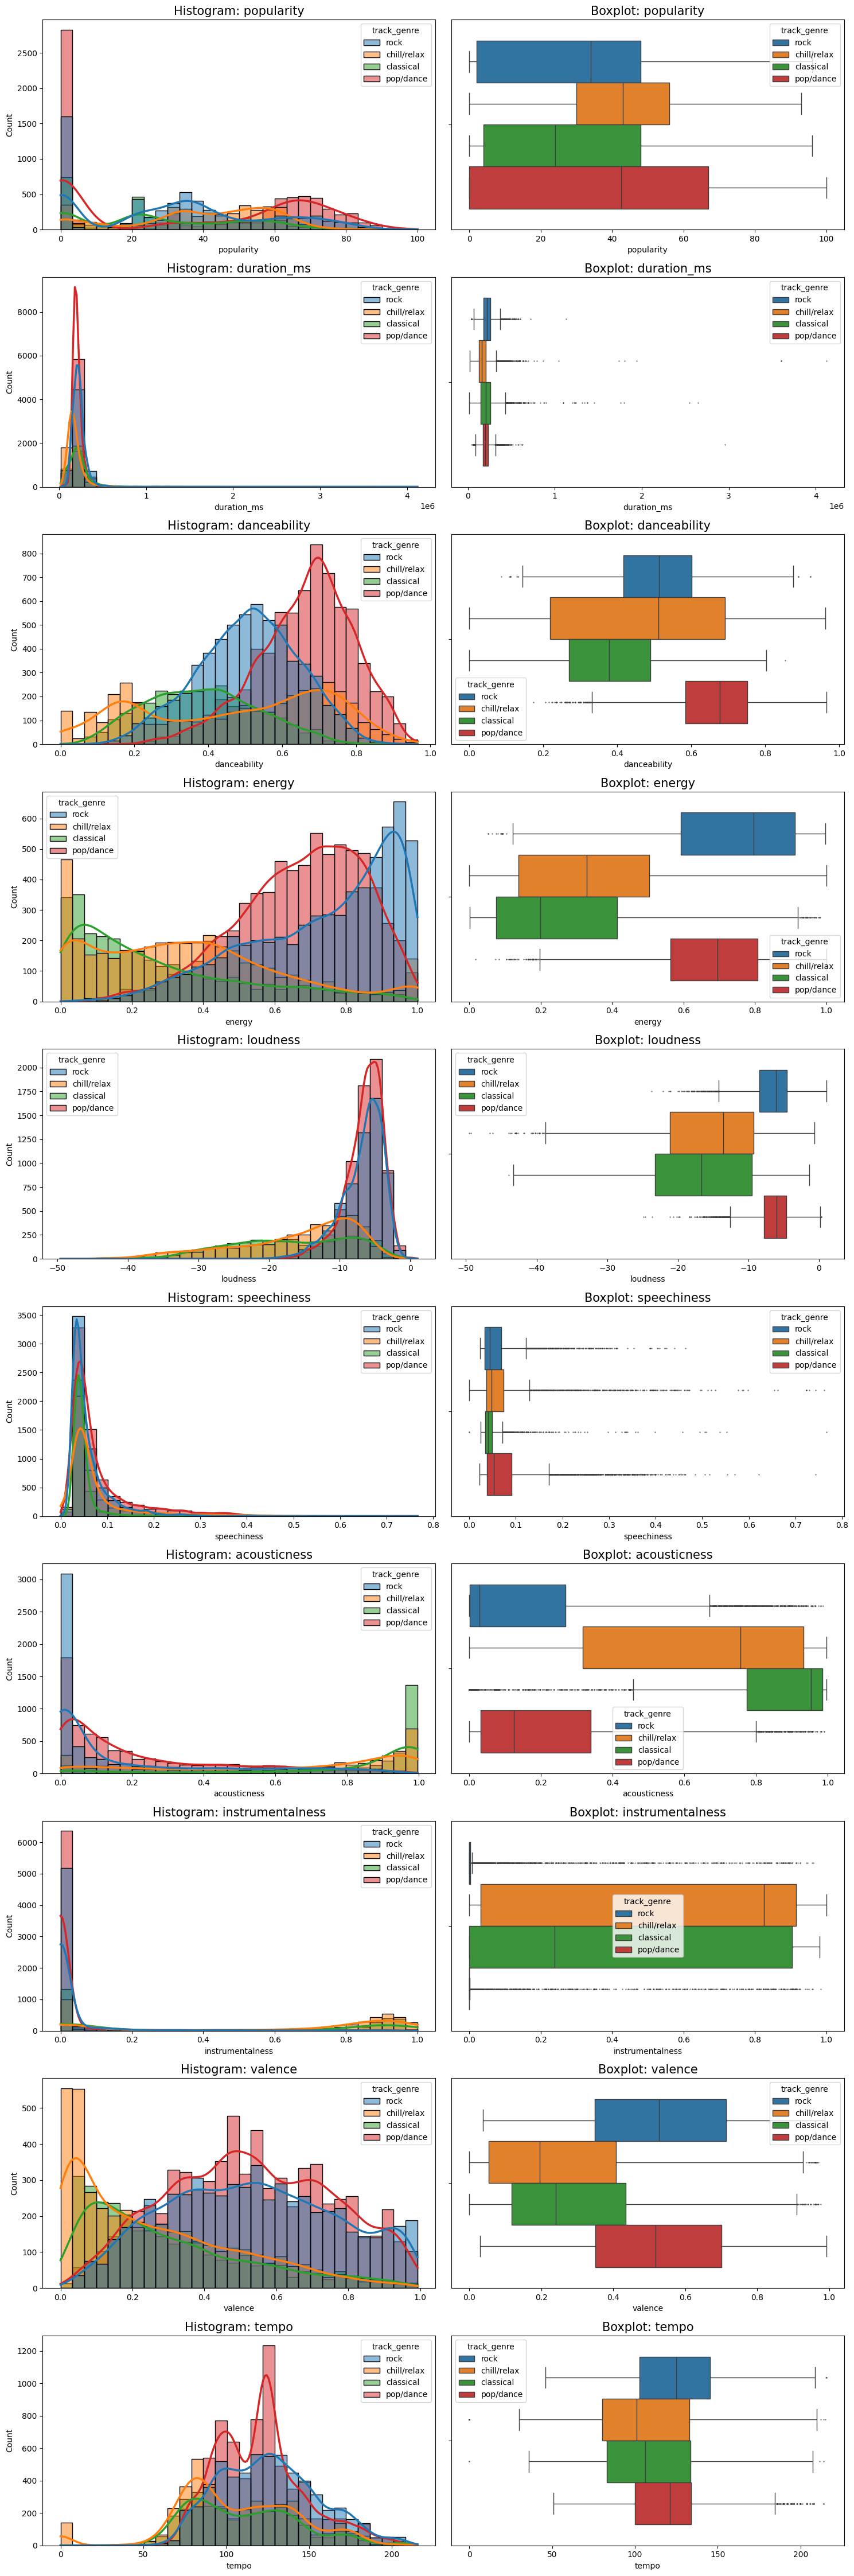

In [73]:
plt.figure(figsize=(15, 45))
for i, column in enumerate(COLUMNS_NUMERICAL):
    
    plt.subplot(10, 2, i*2 + 1)
    sns.histplot(data=df, x=column, bins=30, hue='track_genre', kde=True, line_kws={'linewidth': 2.5})
    plt.title(f"Histogram: {column}", fontsize=15)
    
    plt.subplot(10, 2, i*2 + 2)
    sns.boxplot(data=df, x=column, hue='track_genre', fliersize=0.5)
    plt.title(f"Boxplot: {column}", fontsize=15)   
    
plt.tight_layout()
plt.show()

Powyższa grafika zawiera 20 wykresów - po dwa dla każdego atrybutu. Poniżej znajduje się analiza i wnioski wyciągnięte z wykresów (zarówno histogramu i boxplot) dla każdej cechy:
- popularity - Pierwszą obserwacją, która rzuca się w oczy jest duża liczba piosenek, które uzyskują na tym atrybucie wartość 0 (szczególnie co dość nieintuicyjne z gatunku pop/dance) - jest to spowodowane obecnością w zbiorze danych piosenek, które pochodzą z niepopularnych playlist dostępnych w serwisie Spotify. Mimo tego, że piosenka jest popularna może mieć niską wartość popularity w zbiorze danych, ponieważ znajduje się na słabo odsłuchiwanej playliście. Oprócz tego można zauważyć, że wartości dla każdego gatunku są dość podobne. Nieco wyróżnia się chill/relax, dla którego rozstęp międzykwartylowy jest dość mały (co widać na boxplocie). Praktycznie wszystkie gatunki przyjmują wartości z zakresu od 0 do 90-100.
- duration_ms - Zdecydowana większość wartości na tym atrybucie skoncentrowana jest wokół wartości około 4 minut, co dobrze widać również w tabeli, która zaprezentowana została wcześniej, w sekcji [Opis-zbioru-danych](#Opis-zbioru-danych):

|      | duration_ms |
|------|:-----------:|
| mean |    210724   |
|  std |    100639   |
|  min |    17453    |
|  25% |    162897   |
|  50% |    200081   |
|  75% |    242437   |
|  max |   4120258   |

Występują jednak wartości które mocno odstają od standardowych dla gatunków chill/relax oraz classical (i jedna dla pop/dance). Z tego powodu z histogram jest praktycznie płaski po prawej stronie. Na wykresach boxplot widać jednak, że długości utworów w poszczególnych gatunkach nie odbiegają od siebie znacząco. Największy rozstęp międzykwartylowy uzyskuje gatunek classical, a najmniejszy pop/dance, co widać również na wykresie KDE.
- danceability - Jest to jeden z atrybutów, na którym można dokonać rozróżnienia gatunków, a szczególnie pop/dance. Utwory z tego gatunku osiągają wyższe wartości (mniej więcej pomiędzy 0.6 a 0.8) w porównaniu do innych. Niskie wartości uzyskuje muzyka klasyczna, ale można zauważyć, że wykres KDE jest o wiele bardziej spłaszczony niż w przypadku pop/dance (co ma swoje odzwierciedlenie również w boxplocie). Ciekawa sytuacja występuje dla chill/relax, ponieważ wykres KDE posiada dwa wzniesienia - jedno w okolicy wartości 0.2, a drugie dla około 0.7. Dla rocka średnia wynosi około 0.5, ale rozproszenie jest o mniejsze niż dla muzyki klasycznej oraz chill/relax. Widać to zarówno na histogramie i KDE (mniej słupków, ale są za to wyższe) oraz na boxplocie (mniejszy IQR).
- energy - Na tym atrybucie widzimy zdecydowaną różnicę pomiędzy parami (chill/relax, classical) oraz (rock, pop/dance). Utwory z drugiej pary osiągają znacznie wyższe wartości na tym atrybucie. Dla muzyki klasycznej możemy na wykresie KDE zaobserwować, że im wyższa wartość energy, tym mniej utworów. Podobnie dla chill/relax (chociaż wartości są średnio wyższe dla tego gatunku co widać na boxplocie). Najwyższe wartości uzyskuje rock (widać asymetrię lewostronną rozkładu na histogramie), a tuż za nim jest pop/dance.
- loudness - Podobnie jak dla energy, tak samo dla loudness widać różnicę pomiędzy parami (chill/relax, classical) oraz (rock, pop/dance).
- speechiness - Ten atrybut dla każdego z gatunków wypada mniej więcej podobnie (głównie są to wartości pomiędzy 0 a 0.1), ponieważ nie są analizowane gatunki, w których występuje jedynie głos, a nie ma muzyki. Istnieje również duża liczba outlierów (co widać na boxplocie) - i co może być zaskakujące, nawet jeden dość mocny (wartość ponad 0.7) dla classical - [Sri Venkatesa Suprabhatham](https://open.spotify.com/track/4sBnf3uV6Kbn9d8A3wtN0l?si=669222af4a2648df). W ogólności jednak największe IQR ma na tym atrybucie pop/dance, co jest zrozumiałe, ponieważ mogą się pojawić w tych piosenkach również fragmenty rapowe.
- acousticness - Atrybut acousticness ponownie pozwala na rozróżnienie par (chill/relax, classical) oraz (rock, pop/dance), tym razem pozwalając jednak na lepsze wyszczególnienie muzyki klasycznej. Zazwyczaj jest ona nagrywana na żywo, bez dużej obróbki dźwięku, więc osiąga duże wartości (głównie pomiędzy 0.8 a 1.0) na tym atrybucie. Gatunek chill/relax przyjmuej wartości praktycznie z całego zakresu czyli od 0 do 1, ale ma niewielkie wzniesienie w okolicach 0.9. Najmniej acoustic są utwory rock, z których duża część osiąga wartość bliską 0 co widoczne jest na histogramie. Podobnie dla piosenek pop/dance, chociaż w tym przypadku wykres KDE spada wolniej niż dla rocka.
- instrumentalness - Sytuacja wygląda podobnie jak w przypadku acousticness, ale tutaj boxploty dla rocka oraz pop/dance są praktycznie w całości ściśnięte do 0. Utwory z gatunków classical oraz chill/relax przyjmują wartości z całego zakresu możliwych wartości, przy czym dla chill/relax można zaobserwować niewielkie wzniesienie od 0.8 do 1.0 na wykresie KDE. Wartość mediany na tym atrybucie również znajduje się z okolicach wartości 0.8. 
- valence - Na tym atrybucie utwory pop/dance oraz rock przyjmują bardzo podobne wartości, wykresy KDE praktycznie nachodzą na siebie. Wyróżnia się tutaj gatunek chill/relax, dla którego duża liczba utworów (ponad 1000) ma wartości bliskie 0. Na wykresie KDE dla tego gatunku widać zdecydowanie asymetrię prawostronną). Podobna sytuacja zachodzi dla muzyki klasycznej, chociaż jest on przesunięty nieco w prawo oraz spłaszczony w porównaniu do wykresu dla chill/relax.
- tempo - Dla tego atrybutu wszystkie gatunki wypadają podobnie, trudno zauważyć bardzo znaczące różnice. Największą medianę osiąga rock, później pop/dance, muzyka klasyczna, a na końcu znajduje się chill/relax co zgadzałoby się z intuicją. Dla chill/relax oraz classical rozkłady są najbardziej spłaszczone.

Wnioski z analizy: \
Przed klasyfikatorami postawione zostanie naprawdę trudne zadanie. Rozróżnienie pomiędzy (chill/relax lub classical) albo (rock lub pop/dance) powinno być łatwiejsze niż pomiędzy wnętrzami przedstawionych par. W szczególności rock pop/dance mają niewiele cech dostępnych w zbiorze danych, które mocno odróżniają je pomiędzy sobą. 

### Macierz korelacji

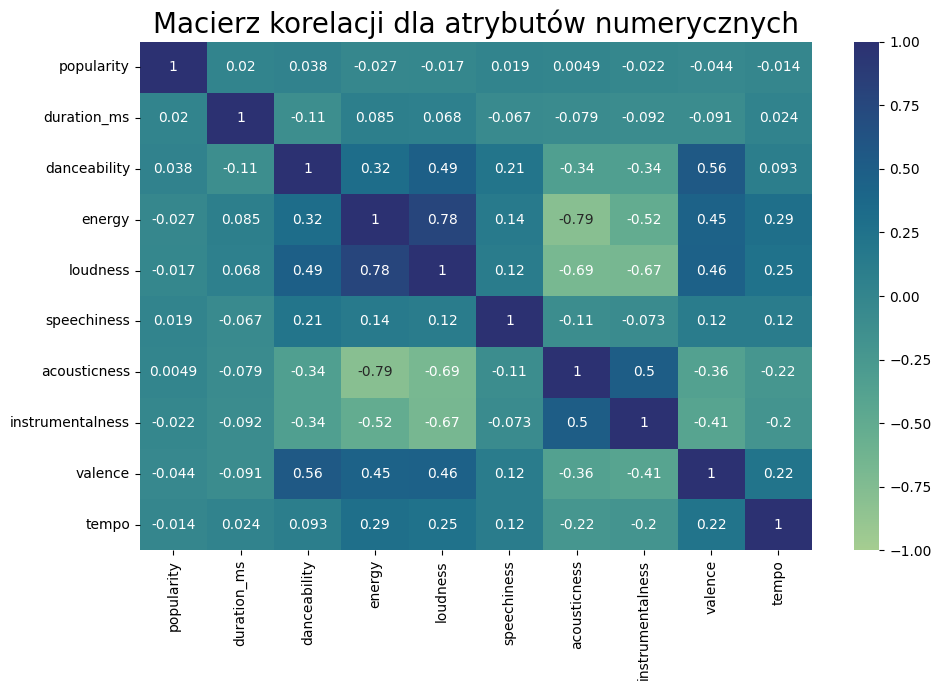

In [17]:
corr = df[COLUMNS_NUMERICAL].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='crest', vmin=-1, vmax=1)
plt.title("Macierz korelacji dla atrybutów numerycznych", fontsize=20)
plt.tight_layout()
plt.show()

## Analiza atrybutów nominalnych

### Wykresy słupkowe

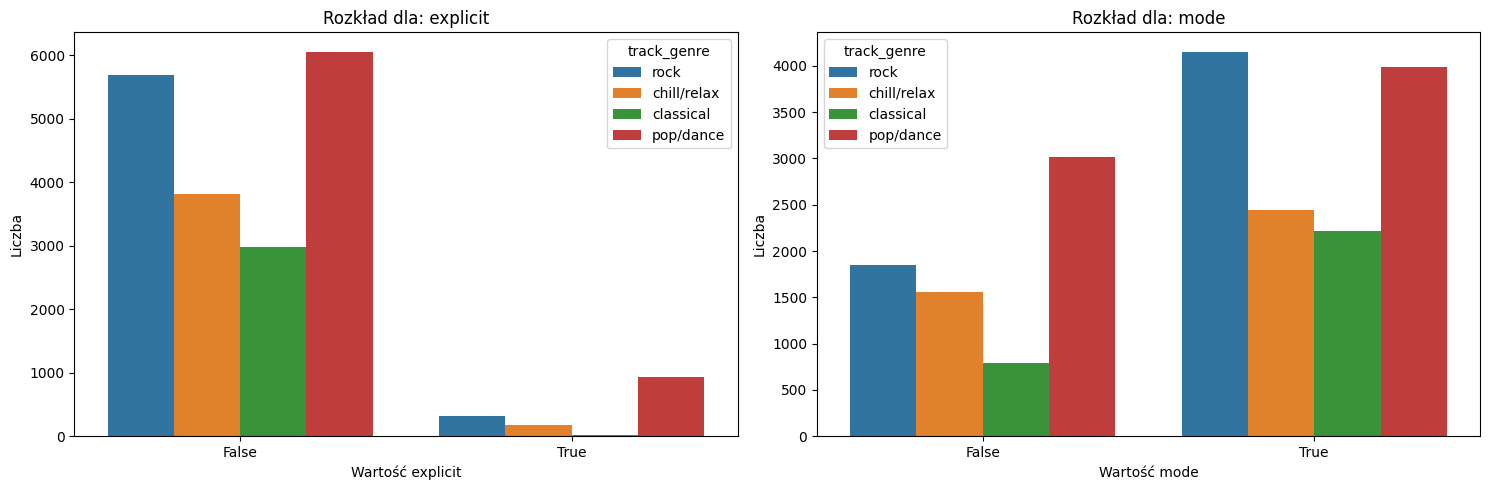

In [18]:
plt.figure(figsize=(15, 5))
for i, column in enumerate(COLUMNS_NOMINAL):
    plt.subplot(1, len(COLUMNS_NOMINAL), i + 1)
    sns.countplot(data=df, x=column, hue='track_genre')
    plt.title(f"Rozkład dla: {column}")
    plt.ylabel("Liczba")
    plt.xlabel(f"Wartość {column}")
plt.tight_layout()
plt.show()

# Modele uczenia maszynowego

## Przygotowanie danych

Podział danych na zbiór treningowy oraz testowy.

In [20]:
X, y = df.drop(columns='track_genre'), df['track_genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE, stratify=y)

## KNN - K najbliższych sąsiadów

In [21]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

 chill/relax       0.53      0.47      0.49       600
   classical       0.46      0.29      0.36       450
   pop/dance       0.60      0.71      0.65      1050
        rock       0.53      0.55      0.54       900

    accuracy                           0.55      3000
   macro avg       0.53      0.50      0.51      3000
weighted avg       0.54      0.55      0.54      3000



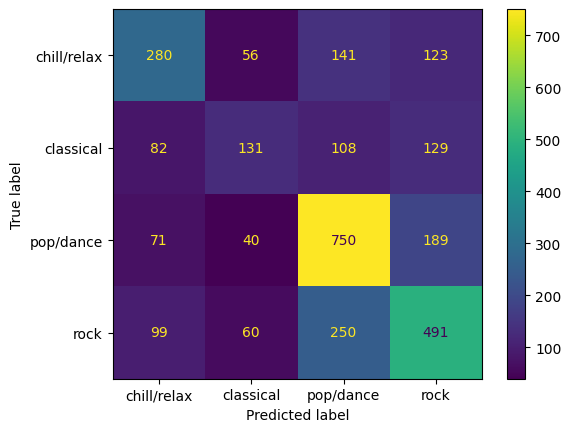

In [22]:
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

Wersja ze standaryzacją:

Best parameters: {'knn__n_neighbors': 9, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

 chill/relax       0.80      0.73      0.76       600
   classical       0.75      0.68      0.71       450
   pop/dance       0.80      0.87      0.83      1050
        rock       0.80      0.81      0.81       900

    accuracy                           0.80      3000
   macro avg       0.79      0.77      0.78      3000
weighted avg       0.79      0.80      0.79      3000



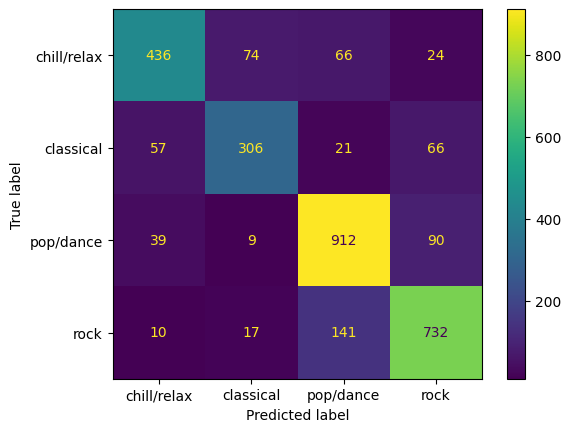

In [23]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.named_steps['knn'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['knn'].classes_)
disp.plot();

## Naive Bayes

              precision    recall  f1-score   support

 chill/relax       0.59      0.45      0.51       600
   classical       0.61      0.30      0.40       450
   pop/dance       0.49      0.80      0.61      1050
        rock       0.48      0.33      0.39       900

    accuracy                           0.51      3000
   macro avg       0.54      0.47      0.48      3000
weighted avg       0.53      0.51      0.49      3000



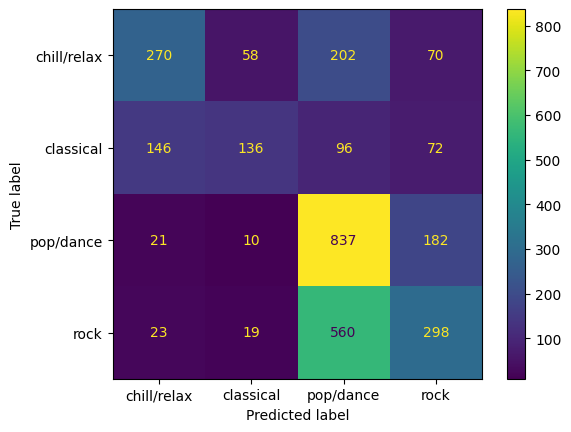

In [24]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot();

Wersja ze standaryzacją

              precision    recall  f1-score   support

 chill/relax       0.78      0.36      0.50       600
   classical       0.46      0.79      0.58       450
   pop/dance       0.70      0.65      0.67      1050
        rock       0.63      0.68      0.65       900

    accuracy                           0.62      3000
   macro avg       0.64      0.62      0.60      3000
weighted avg       0.66      0.62      0.62      3000



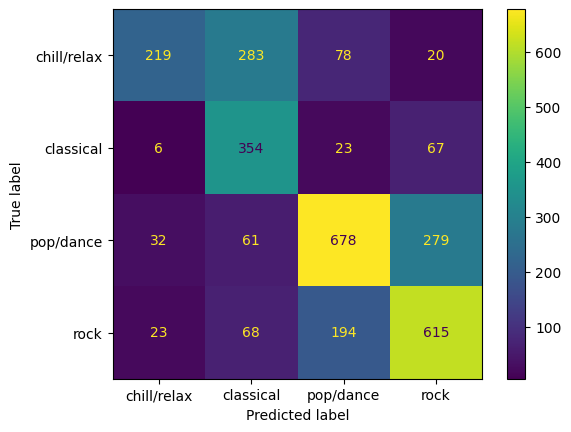

In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=pipeline.named_steps['gnb'].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.named_steps['gnb'].classes_)
disp.plot();

## Drzewo decyzyjne

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
              precision    recall  f1-score   support

 chill/relax       0.75      0.71      0.73       600
   classical       0.74      0.63      0.68       450
   pop/dance       0.76      0.82      0.79      1050
        rock       0.74      0.76      0.75       900

    accuracy                           0.75      3000
   macro avg       0.75      0.73      0.74      3000
weighted avg       0.75      0.75      0.75      3000



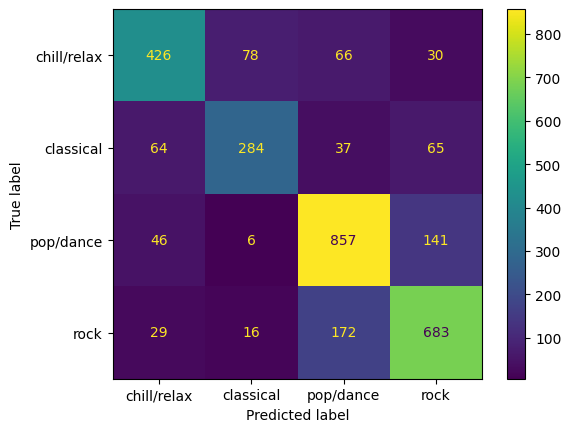

In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

## Las losowy

Best parameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 400}
              precision    recall  f1-score   support

 chill/relax       0.82      0.76      0.79       600
   classical       0.78      0.70      0.74       450
   pop/dance       0.83      0.88      0.85      1050
        rock       0.83      0.86      0.85       900

    accuracy                           0.82      3000
   macro avg       0.82      0.80      0.81      3000
weighted avg       0.82      0.82      0.82      3000



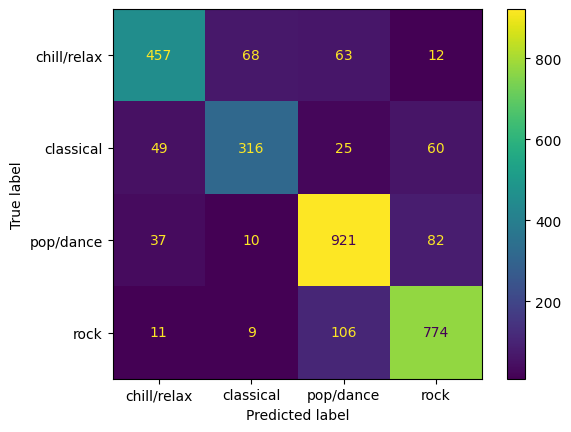

In [27]:
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

## AdaBoost

Best parameters: {'learning_rate': 1.0, 'n_estimators': 400}
              precision    recall  f1-score   support

 chill/relax       0.69      0.74      0.71       600
   classical       0.65      0.46      0.54       450
   pop/dance       0.73      0.75      0.74      1050
        rock       0.70      0.74      0.72       900

    accuracy                           0.70      3000
   macro avg       0.69      0.67      0.68      3000
weighted avg       0.70      0.70      0.70      3000



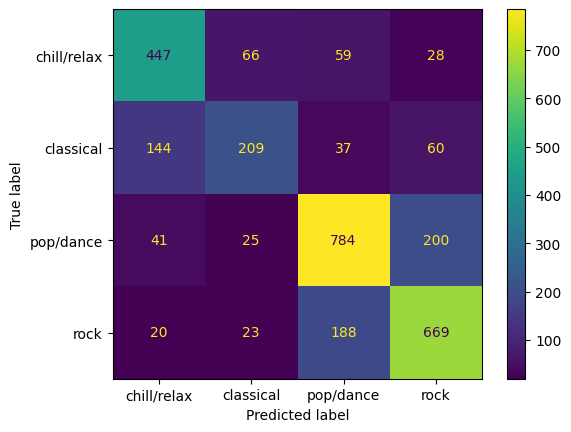

In [28]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

grid_search = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot();

## TPOT

In [31]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
# Commented out because it takes about 2h to complete the training
# tpot.fit(X_train, y_train)
# tpot.export('tpot_output.py')

Model znaleziony przy pomocy TPOT to GradientBoostingClassifier.

              precision    recall  f1-score   support

 chill/relax       0.81      0.80      0.81       600
   classical       0.79      0.71      0.75       450
   pop/dance       0.84      0.86      0.85      1050
        rock       0.82      0.85      0.84       900

    accuracy                           0.82      3000
   macro avg       0.82      0.81      0.81      3000
weighted avg       0.82      0.82      0.82      3000



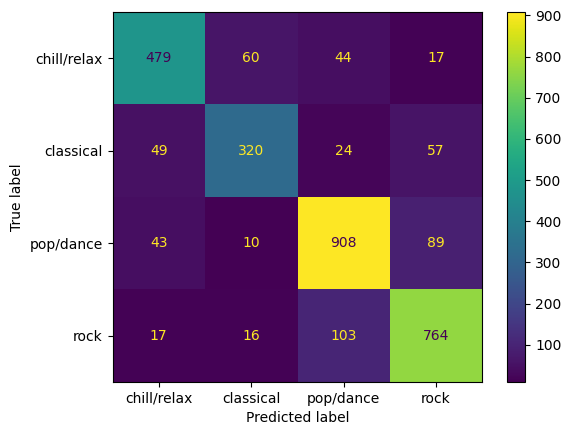

In [32]:
model = GradientBoostingClassifier(learning_rate=0.5, max_depth=8, max_features=0.8, min_samples_leaf=20, min_samples_split=12, n_estimators=100, subsample=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
disp.ax_.set_title("GradientBoostingClassifier");

# Wnioski i podsumowanie modeli

# Źródła

# Wykorzystane biblioteki oraz pakiety